https://www.kaggle.com/c/costa-rican-household-poverty-prediction

**Id** - a unique identifier for each row.

**Target** - the target is an ordinal variable indicating groups of income levels.

1 = extreme poverty

2 = moderate poverty

3 = vulnerable households

4 = non vulnerable households

**idhogar** - this is a unique identifier for each household. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier.

**parentesco1** - indicates if this person is the head of the household.

This data contains 142 total columns.

In [177]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Patch
from sklearn.metrics import accuracy_score


# Import data and get to know the data

## Import

In [3]:
from google.colab import files
files.upload();

Saving test.csv to test.csv
Saving train.csv to train.csv


In [229]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

## Get to know the data

### Get to know data general

In [140]:
train_shape = train_data.shape
print("Train Data Shape:", train_shape)

test_shape = test_data.shape
print("Test Data Shape:", test_shape)

Train Data Shape: (9557, 143)
Test Data Shape: (23856, 142)


In [141]:
data_types_dict = {}

for column in train_data.columns:
    col_type = str(train_data[column].dtype)
    if col_type not in data_types_dict:
        data_types_dict[col_type] = []
    data_types_dict[col_type].append(column)

for data_type, columns in data_types_dict.items():
    print(f"Data type: {data_type}")
    print(f"Columns: {', '.join(columns)}\n")


Data type: object
Columns: Id, idhogar, dependency, edjefe, edjefa

Data type: float64
Columns: v2a1, v18q1, rez_esc, meaneduc, overcrowding, SQBovercrowding, SQBdependency, SQBmeaned

Data type: int64
Columns: hacdor, rooms, hacapo, v14a, refrig, v18q, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tamhog, tamviv, escolari, hhsize, paredblolad, paredzocalo, paredpreb, pareddes, paredmad, paredzinc, paredfibras, paredother, pisomoscer, pisocemento, pisoother, pisonatur, pisonotiene, pisomadera, techozinc, techoentrepiso, techocane, techootro, cielorazo, abastaguadentro, abastaguafuera, abastaguano, public, planpri, noelec, coopele, sanitario1, sanitario2, sanitario3, sanitario5, sanitario6, energcocinar1, energcocinar2, energcocinar3, energcocinar4, elimbasu1, elimbasu2, elimbasu3, elimbasu4, elimbasu5, elimbasu6, epared1, epared2, epared3, etecho1, etecho2, etecho3, eviv1, eviv2, eviv3, dis, male, female, estadocivil1, estadocivil2, estadocivil3, estadocivil4, estadocivil5, est

In [142]:
test_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [143]:
train_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


### Proportion of heads of households

ONLY the heads of household are used in scoring.
All household members are included in test + the sample submission, but only heads of households are scored.

Because of that:
1. Create dataset only for rows with heads of households ID-s.
2. Calculate additional features using data of other members of the household.


In [144]:
proportion_of_heads_train = round(train_data[train_data['parentesco1'] == 1].shape[0]/len(train_data)*100)
proportion_of_non_heads_train = round(train_data[train_data['parentesco1'] == 0].shape[0]/len(train_data)*100)

proportion_of_heads_test = round(test_data[test_data['parentesco1'] == 1].shape[0]/len(test_data)*100)
proportion_of_non_heads_test = round(test_data[test_data['parentesco1'] == 0].shape[0]/len(test_data)*100)

print("Proportion of heads of households in train:", proportion_of_heads_train)
print("Proportion of other members of households in train:", proportion_of_non_heads_train)

print("Proportion of heads of households in test:", proportion_of_heads_test)
print("Proportion of other members of households in test:", proportion_of_non_heads_test)

Proportion of heads of households in train: 31
Proportion of other members of households in train: 69
Proportion of heads of households in test: 31
Proportion of other members of households in test: 69


### Find values that could be used for calcualting additional household variables

In [147]:
# names of variables that are not the same for all household members
variables_not_same = []

for column in train_data.columns:
    if column != 'idhogar':
        grouped = train_data.groupby('idhogar')[column].nunique()
        if any(grouped > 1):
            variables_not_same.append(column)

print("Variables not same for each member of the household:")
for variable in variables_not_same:
    print(variable)

Variables not same for each member of the household:
Id
escolari
rez_esc
dis
male
female
estadocivil1
estadocivil2
estadocivil3
estadocivil4
estadocivil5
estadocivil6
estadocivil7
parentesco1
parentesco2
parentesco3
parentesco4
parentesco5
parentesco6
parentesco7
parentesco8
parentesco9
parentesco10
parentesco11
parentesco12
instlevel1
instlevel2
instlevel3
instlevel4
instlevel5
instlevel6
instlevel7
instlevel8
instlevel9
age
SQBescolari
SQBage
agesq
Target


* Id
* escolari, years of schooling
* rez_esc, Years behind in school
* dis, =1 if disable person
* male, =1 if male
* female, =1 if female
* estadocivil1, =1 if less than 10 years old
* estadocivil2, =1 if free or coupled uunion
* estadocivil3, =1 if married
* estadocivil4, =1 if divorced
* estadocivil5, =1 if separated
* estadocivil6, =1 if widow/er
* estadocivil7, =1 if single
* parentesco1, =1 if household head
* parentesco2, =1 if spouse/partner
* parentesco3, =1 if son/doughter
* parentesco4, =1 if stepson/doughter
* parentesco5, =1 if son/doughter in law
* parentesco6, =1 if grandson/doughter
* parentesco7, =1 if mother/father
* parentesco8, =1 if father/mother in law
* parentesco9, =1 if brother/sister
* parentesco10, =1 if brother/sister in law
* parentesco11, =1 if other family member
* parentesco12, =1 if other non family member
* instlevel1, =1 no level of education
* instlevel2, =1 incomplete primary
* instlevel3, =1 complete primary
* instlevel4, =1 incomplete academic secondary level
* instlevel5, =1 complete academic secondary level
* instlevel6, =1 incomplete technical secondary level
* instlevel7, =1 complete technical secondary level
* instlevel8, =1 undergraduate and higher education
* instlevel9, =1 postgraduate higher education
* age, Age in years
* SQBescolari, escolari squared
* SQBage, age squared
* agesq
* Target

### Distribution of income levels (the target variable)

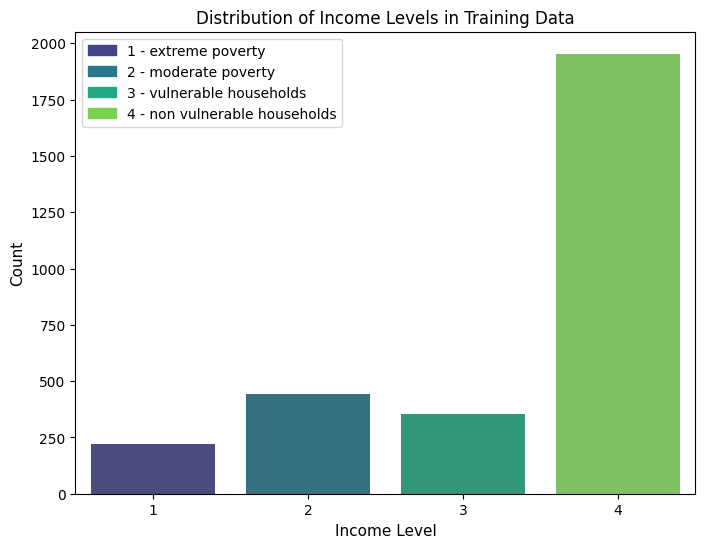

In [152]:
palette = sns.color_palette("viridis", n_colors=4)

# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=train_data[train_data['parentesco1'] == 1], palette=palette)
plt.title('Distribution of Income Levels in Training Data', size=12)
plt.xlabel('Income Level', size=11)
plt.ylabel('Count', size=11)

# Define the legend
legend_labels = {
    1: '1 - extreme poverty',
    2: '2 - moderate poverty',
    3: '3 - vulnerable households',
    4: '4 - non vulnerable households'
}

# Create legend patches
legend_patches = [Patch(color=palette[i], label=label) for i, label in enumerate(legend_labels.values())]

# Add legend to the plot
plt.legend(handles=legend_patches)
plt.show()

Data is unbalanced between target classes.

# Data imputation and calculating household statistics

## Variables with Null values

In [154]:
# heads of households
train_data_heads_of_household_original = train_data[train_data['parentesco1'] == 1]

columns_with_missing_values = train_data_heads_of_household_original.columns[train_data_heads_of_household_original.isnull().any()]

# percentage of missing values for these columns
percent_missing = train_data_heads_of_household_original[columns_with_missing_values].isnull().sum() / len(train_data_heads_of_household_original) * 100
print("Percentage of Missing Values for Each Column:")
print(percent_missing)

Percentage of Missing Values for Each Column:
v2a1         72.519341
v18q1        77.968382
rez_esc      99.966364
meaneduc      0.100908
SQBmeaned     0.100908
dtype: float64




*   v2a1, Monthly rent payment
*   v18q1, number of tablets household owns



How rent is distributed at the moment.

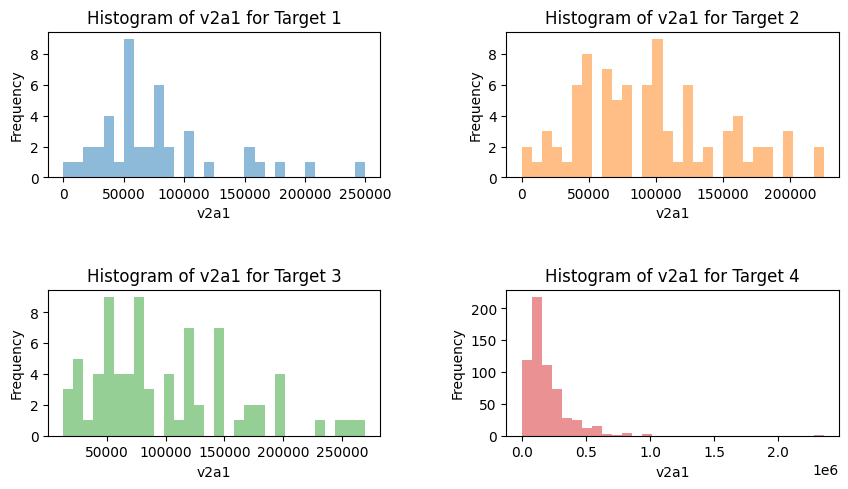

In [159]:
# function for plotting values per target group
def plot_histograms_by_target(data, column, target_column, nrows=2, ncols=2, figsize=(10, 6)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.tight_layout(pad=6.0)

    targets = sorted(data[target_column].unique())
    for idx, target in enumerate(targets):

        row, col = divmod(idx, ncols)
        ax = axes[row, col]

        ax.hist(data[data[target_column] == target][column], bins=30, alpha=0.5, color=f'C{idx}')
        ax.set_title(f'Histogram of {column} for {target_column} {target}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plt.show()

plot_histograms_by_target(train_data_heads_of_household_original, 'v2a1', 'Target')

If to use mean to fill Null values.

In [160]:
train_data_heads_of_household = train_data_heads_of_household_original.copy()

# Filling NaN values for 'v2a1' with its mean
v2a1_mean = train_data_heads_of_household['v2a1'].mean()
train_data_heads_of_household['v2a1'].fillna(v2a1_mean, inplace=True)

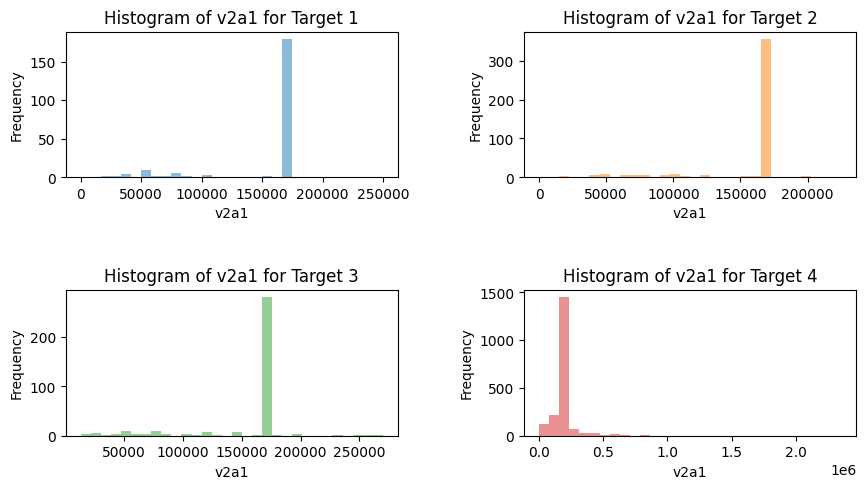

In [161]:
plot_histograms_by_target(train_data_heads_of_household, 'v2a1', 'Target')

Mean does not follow data distrbution.

Try KNNImputer.

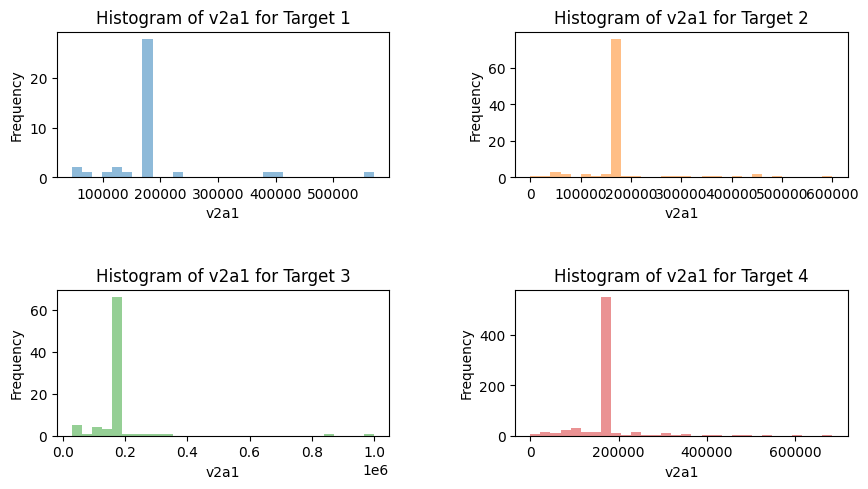

In [162]:
train_data_heads_of_household = train_data_heads_of_household_original.copy()

columns_to_impute = ['v2a1']
data_to_impute = train_data_heads_of_household[columns_to_impute]
imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(data_to_impute)
imputed_data = pd.DataFrame(imputed_values, columns=columns_to_impute)
train_data_heads_of_household[columns_to_impute] = imputed_data

plot_histograms_by_target(train_data_heads_of_household, 'v2a1', 'Target')

KNNImputer graphs look slightly more reasonable.

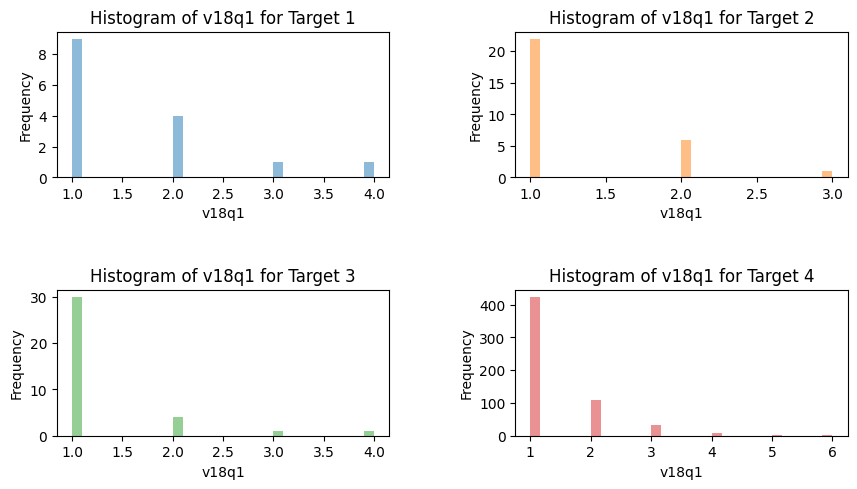

In [163]:
plot_histograms_by_target(train_data_heads_of_household_original, 'v18q1', 'Target')

v18q1 - number of tablets, don't do data imputation, would probably have biased results.

## Create functions and prep data

In [164]:
# Impute missing values in selected columns
def impute_missing_values(data, columns_to_impute):
    imputer = KNNImputer(n_neighbors=5)
    imputed_values = imputer.fit_transform(data[columns_to_impute])
    return pd.DataFrame(imputed_values, columns=columns_to_impute)

def process_data(train_data, marital_status_columns, relationship_columns, education_level_columns):
    # Select only heads of households
    train_data_heads_of_household = train_data[train_data['parentesco1'] == 1].copy()

    columns_to_impute = ['v2a1']
    train_data_heads_of_household[columns_to_impute] = impute_missing_values(train_data_heads_of_household, columns_to_impute)

    columns_to_replace = ['v18q1', 'meaneduc', 'SQBmeaned', 'v2a1']
    train_data_heads_of_household[columns_to_replace] = train_data_heads_of_household[columns_to_replace].fillna(0)

    # aggregate calculations for escolari and rez_esc
    household_stats = train_data.groupby('idhogar').agg({
        'escolari': ['mean', 'sum', 'min', 'max', 'std'],
        'rez_esc': ['mean', 'sum', 'min', 'max', 'std']
    }).reset_index()
    household_stats.columns = ['idhogar' if col[0] == 'idhogar' else '_'.join(col).strip() for col in household_stats.columns]

    # Impute missing values in household_stats
    columns_to_impute = ['escolari_mean', 'escolari_sum', 'escolari_min', 'escolari_max', 'escolari_std', 'rez_esc_mean', 'rez_esc_sum', 'rez_esc_min', 'rez_esc_max', 'rez_esc_std']
    household_stats[columns_to_impute] = impute_missing_values(household_stats, columns_to_impute)

    dis_counts = train_data.groupby('idhogar')['dis'].sum().to_dict()
    male_counts = train_data.groupby('idhogar')['male'].sum().to_dict()
    female_counts = train_data.groupby('idhogar')['female'].sum().to_dict()

    # Calculate and add ratios
    def calculate_ratios(household_stats, column_dict, column_ratio_name):
        household_size = train_data.groupby('idhogar').size()
        household_stats[column_ratio_name] = household_stats['idhogar'].map(column_dict) / household_stats['idhogar'].map(household_size)

    calculate_ratios(household_stats, dis_counts, 'dis_ratio')
    calculate_ratios(household_stats, male_counts, 'male_ratio')
    calculate_ratios(household_stats, female_counts, 'female_ratio')

    # Calculate counts and ratios for each category
    def calculate_category_ratios(data, category_columns):
        household_size = train_data.groupby('idhogar').size()
        for column in category_columns:
            column_sum = train_data.groupby('idhogar')[column].sum().to_dict()
            data[f'{column}_count'] = data['idhogar'].map(column_sum)
            data[f'{column}_ratio'] = data[f'{column}_count'] / data['idhogar'].map(household_size)

    calculate_category_ratios(household_stats, marital_status_columns)
    calculate_category_ratios(household_stats, relationship_columns)
    calculate_category_ratios(household_stats, education_level_columns)


    # Merge additional stats into train_data_heads_of_household
    train_data_heads_of_household_additional_stats = train_data_heads_of_household.merge(household_stats, on='idhogar')

    # Drop columns that apply only for the head of household
    columns_to_drop = [
        'escolari', 'rez_esc', 'dis', 'male', 'female',
    'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7',
    'parentesco1', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12',
    'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'idhogar', 'dependency', 'edjefe', 'edjefa']

    train_data_heads_of_household_additional_stats = train_data_heads_of_household.drop(columns=columns_to_drop)

    return train_data_heads_of_household_additional_stats


In [165]:
marital_status_columns = ['estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7']
relationship_columns = ['parentesco1', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12']
education_level_columns = ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']

train_data_heads_of_household_additional_stats = process_data(train_data, marital_status_columns, relationship_columns, education_level_columns)

In [166]:
marital_status_columns = ['estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7']
relationship_columns = ['parentesco1', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12']
education_level_columns = ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']

test_data_heads_of_household_additional_stats = process_data(test_data, marital_status_columns, relationship_columns, education_level_columns)

# Models

## K-Nearest Neighbours (KNN)

## train_data_heads_of_household_original

### 1. original target groups

In [256]:
train_data_heads_of_household_original = train_data[train_data['parentesco1'] == 1]
train_data_heads_of_household_original = train_data_heads_of_household_original.drop('dependency', axis=1)

features = train_data_heads_of_household_original.drop('Target', axis=1)
target = train_data_heads_of_household_original['Target']

features.drop('Id', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train.drop('idhogar', axis=1, inplace=True)
X_test.drop('idhogar', axis=1, inplace=True)

handled_missing_values = []
for col in X_train.select_dtypes(include='number').columns:
    mean_value = X_train[col].mean()
    X_train[col].fillna(mean_value, inplace=True)
    X_test[col].fillna(mean_value, inplace=True)
    handled_missing_values.append(col)

print("Handled missing values in columns:", handled_missing_values)

label_encoders = {}
encoded_columns = []
for column in X_train.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X_train[column] = label_encoders[column].fit_transform(X_train[column])
    X_test[column] = label_encoders[column].transform(X_test[column])
    encoded_columns.append(column)

print("Encoded categorical variables in columns:", encoded_columns)

Handled missing values in columns: ['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'tamhog', 'tamviv', 'escolari', 'rez_esc', 'hhsize', 'paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera', 'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6', 'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil

In [195]:
for column in X_train.select_dtypes(include=['object']).columns:
    train_unique = set(X_train[column].unique())
    test_unique = set(X_test[column].unique())
    if not test_unique.issubset(train_unique):
        print(f"Column '{column}' has unseen labels in test set.")


### Finding K

K=1: Train Accuracy: 1.0000, Test Accuracy: 0.5361
K=2: Train Accuracy: 0.7691, Test Accuracy: 0.4437
K=3: Train Accuracy: 0.7422, Test Accuracy: 0.5513
K=4: Train Accuracy: 0.7216, Test Accuracy: 0.5647
K=5: Train Accuracy: 0.7094, Test Accuracy: 0.5882
K=6: Train Accuracy: 0.6926, Test Accuracy: 0.5866
K=7: Train Accuracy: 0.6842, Test Accuracy: 0.5983
K=8: Train Accuracy: 0.6867, Test Accuracy: 0.6034
K=9: Train Accuracy: 0.6800, Test Accuracy: 0.6101
K=10: Train Accuracy: 0.6817, Test Accuracy: 0.6050
K=11: Train Accuracy: 0.6745, Test Accuracy: 0.6101
K=12: Train Accuracy: 0.6728, Test Accuracy: 0.6134
K=13: Train Accuracy: 0.6733, Test Accuracy: 0.6202
K=14: Train Accuracy: 0.6720, Test Accuracy: 0.6168
K=15: Train Accuracy: 0.6758, Test Accuracy: 0.6168
K=16: Train Accuracy: 0.6737, Test Accuracy: 0.6185
K=17: Train Accuracy: 0.6728, Test Accuracy: 0.6286
K=18: Train Accuracy: 0.6699, Test Accuracy: 0.6269
K=19: Train Accuracy: 0.6690, Test Accuracy: 0.6185
K=20: Train Accuracy:

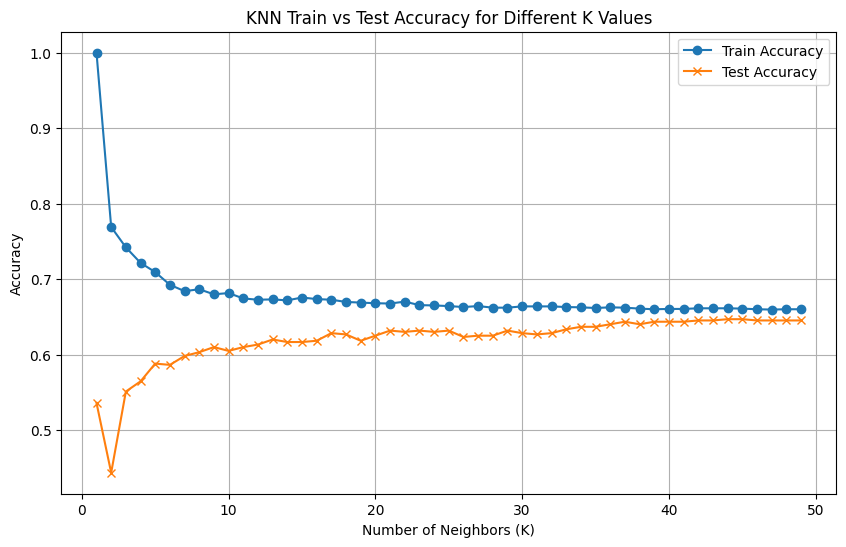

In [202]:
from sklearn.model_selection import validation_curve

k_values = range(1, 50)
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_train_pred = knn.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    y_test_pred = knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

    print(f"K={k}: Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='x')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('KNN Train vs Test Accuracy for Different K Values')
plt.legend()
plt.grid(True)
plt.show()


In [213]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

knn_head_of_household = KNeighborsClassifier(n_neighbors=20)
knn_head_of_household.fit(X_train, y_train)

y_pred = knn_head_of_household.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


print(f"Accuracy for k=20: {accuracy}")

Accuracy for k=20: 0.6252100840336134


### Visualisation function

In [210]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

VIS_TARGET_LABELS = ['1', '2', '3', '4']

def fancy_metric_vis(model, X_test, y_test, xgb_encoder = None):
    n_classes = 4
    fig, ax = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle('Model Metrics')

    plot_confusion_matrix(model, X_test, y_test, ax=ax[0], xgb_encoder = xgb_encoder)
    plot_roc_curve(model, X_test, y_test, n_classes, ax=ax[1])
    plot_pr_curve(model, X_test, y_test, n_classes, ax=ax[2])

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, test_x, test_y, ax, xgb_encoder = None):
    predictions = model.predict(test_x)
    predictions = xgb_encoder.inverse_transform(predictions) if xgb_encoder else predictions
    cm = confusion_matrix(test_y, predictions)
    ax.set_title('Confusion Matrix')

    class_labels = VIS_TARGET_LABELS
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_yticklabels(class_labels)

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(ax=ax, cmap=plt.cm.Blues)

def plot_pr_curve(model, test_x, test_y, n_classes, ax):
    class_labels = ['1', '2', '3', '4']
    test_y_bin = label_binarize(test_y, classes=[1, 2, 3, 4])
    predictions = model.predict_proba(test_x)
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(test_y_bin[:, i], predictions[:, i])
        ax.plot(recall[i], precision[i], lw=2, label=VIS_TARGET_LABELS[i])

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc="best")
    ax.set_title('PR Curve')

def plot_roc_curve(model, test_x, test_y, n_classes, ax):
    test_y_bin = label_binarize(test_y, classes=[1, 2, 3, 4])
    predictions = model.predict_proba(test_x)
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], predictions[:, i])
        ax.plot(fpr[i], tpr[i], lw=2, label=VIS_TARGET_LABELS[i])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="best")
    ax.set_title('ROC Curve')

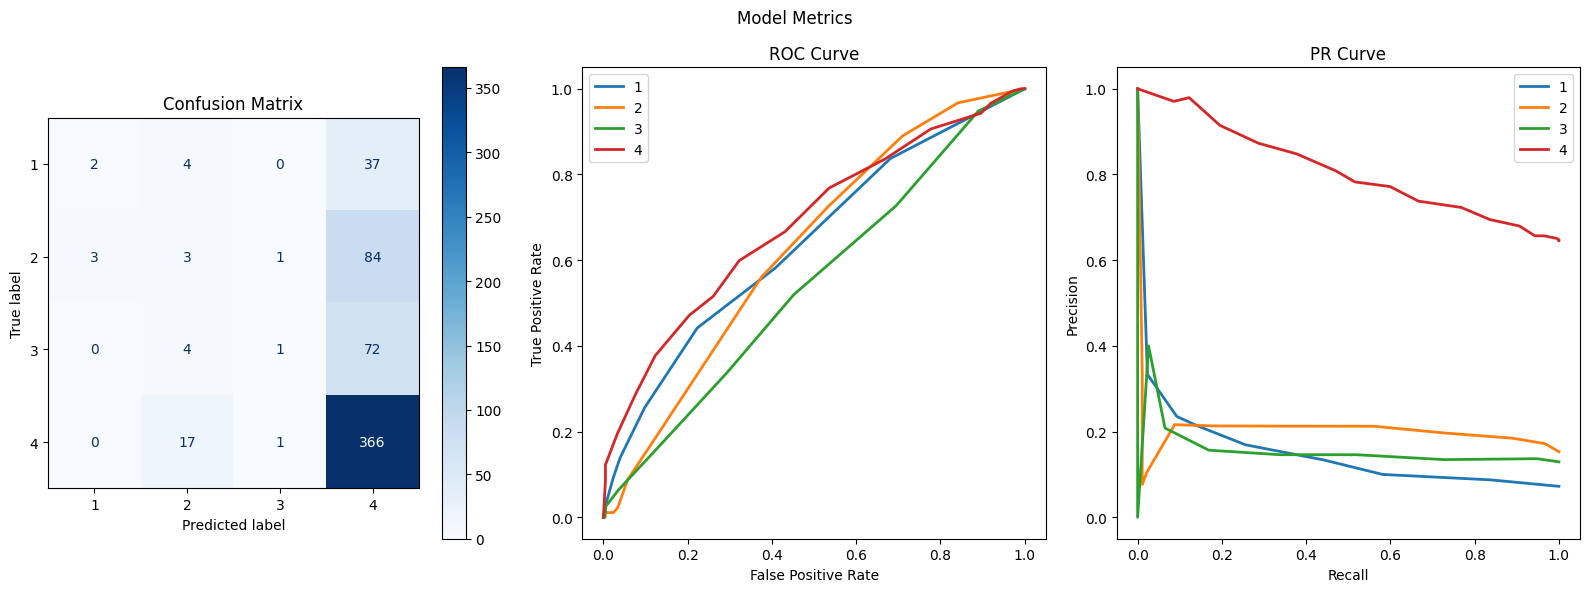

In [212]:
fancy_metric_vis(knn_head_of_household, X_test, y_test)

### Prep for Kaggle

In [246]:
test_data_heads_of_household_original = test_data[test_data['parentesco1'] == 1].copy()
test_data_heads_of_household_original.drop(['Id', 'idhogar', 'dependency'], axis=1, inplace=True)

test_data_heads_of_household_original.fillna(0, inplace=True)

# Encode categorical variables
for column in test_data_heads_of_household_original.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        # Transform using the label encoder created during training
        test_data_heads_of_household_original[column] = label_encoders[column].transform(test_data_heads_of_household_original[column])
    else:
        # Fill unrecognized categorical columns with a default value
        test_data_heads_of_household_original[column] = 0  # or any other default value


predictions = knn_head_of_household.predict(test_data_heads_of_household_original)

In [247]:
# Extracting the household head IDs from the original test_data
household_head_ids = test_data.loc[test_data['parentesco1'] == 1, 'Id']

# Creating a DataFrame with IDs and predictions
household_head_predictions = pd.DataFrame({
    'Id': household_head_ids.values,
    'Target': predictions
})


In [251]:
# Creating a mapping from idhogar to Target
idhogar_to_target = dict(zip(test_data[test_data['parentesco1'] == 1]['idhogar'], predictions))

# Assigning Target values to all members in test_data based on their idhogar
test_data['Target'] = test_data['idhogar'].map(idhogar_to_target)

# Handling cases where some idhogar might not have a household head
# This can be handled in various ways, here we assign a default value (e.g., the most common Target value)
default_target = test_data['Target'].mode()[0]
test_data['Target'] = test_data['Target'].fillna(default_target).astype(int)

# Extracting final Id and Target values
final_predictions = test_data[['Id', 'Target']]


In [255]:
len(final_predictions)

23856

### 2. under and oversampling target class

In [111]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Assuming X_train and y_train are your features and labels respectively

print("Original dataset shape:", Counter(y_train))

# Define the resampling methods
undersample = RandomUnderSampler(sampling_strategy='majority') # Undersample the majority class
oversample = RandomOverSampler(sampling_strategy='minority') # Oversample the minority class

# First, undersampling the majority class
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)
print("After undersampling:", Counter(y_resampled))

# Then, oversampling the minority class
X_resampled, y_resampled = oversample.fit_resample(X_resampled, y_resampled)
print("After oversampling:", Counter(y_resampled))

# Now X_resampled and y_resampled are the balanced training set


Original dataset shape: Counter({4: 1954, 2: 442, 3: 355, 1: 222})
After undersampling: Counter({2: 442, 3: 355, 1: 222, 4: 222})
After oversampling: Counter({1: 442, 2: 442, 3: 355, 4: 222})


In [214]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Assuming train_data is your DataFrame

# Selecting heads of household and dropping 'dependency' column
train_data_heads_of_household = train_data[train_data['parentesco1'] == 1]
train_data_heads_of_household = train_data_heads_of_household.drop('dependency', axis=1)

# Separating features and target
features = train_data_heads_of_household.drop('Target', axis=1)
target = train_data_heads_of_household['Target']

# Dropping 'Id' column from features
features.drop('Id', axis=1, inplace=True)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Dropping 'idhogar' column from training and test features
X_train.drop('idhogar', axis=1, inplace=True)
X_test.drop('idhogar', axis=1, inplace=True)

# Handling missing values for numeric columns
handled_missing_values = []
for col in X_train.select_dtypes(include='number').columns:
    mean_value = X_train[col].mean()
    X_train[col].fillna(mean_value, inplace=True)
    X_test[col].fillna(mean_value, inplace=True)
    handled_missing_values.append(col)

print("Handled missing values in columns:", handled_missing_values)

# Encoding categorical variables
label_encoders = {}
encoded_columns = []
for column in X_train.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X_train[column] = label_encoders[column].fit_transform(X_train[column])
    X_test[column] = label_encoders[column].transform(X_test[column])
    encoded_columns.append(column)

print("Encoded categorical variables in columns:", encoded_columns)

# Printing the original dataset shape
print("Original dataset shape:", Counter(y_train))

# Define the resampling methods
undersample = RandomUnderSampler(sampling_strategy='majority') # Undersample the majority class
oversample = RandomOverSampler(sampling_strategy='minority') # Oversample the minority class

# First, undersampling the majority class
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)
print("After undersampling:", Counter(y_resampled))

# Then, oversampling the minority class
X_resampled, y_resampled = oversample.fit_resample(X_resampled, y_resampled)
print("After oversampling:", Counter(y_resampled))

# Now X_resampled and y_resampled are the balanced training set


Handled missing values in columns: ['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'tamhog', 'tamviv', 'escolari', 'rez_esc', 'hhsize', 'paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera', 'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6', 'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil

In [217]:
knn_head_of_household_adjusted_classes = KNeighborsClassifier(n_neighbors=20)
knn_head_of_household_adjusted_classes.fit(X_resampled, y_resampled)

y_pred = knn_head_of_household_adjusted_classes.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy for k=20 (adjusted classes): {accuracy}")

Accuracy for k=20 (adjusted classes): 0.173109243697479


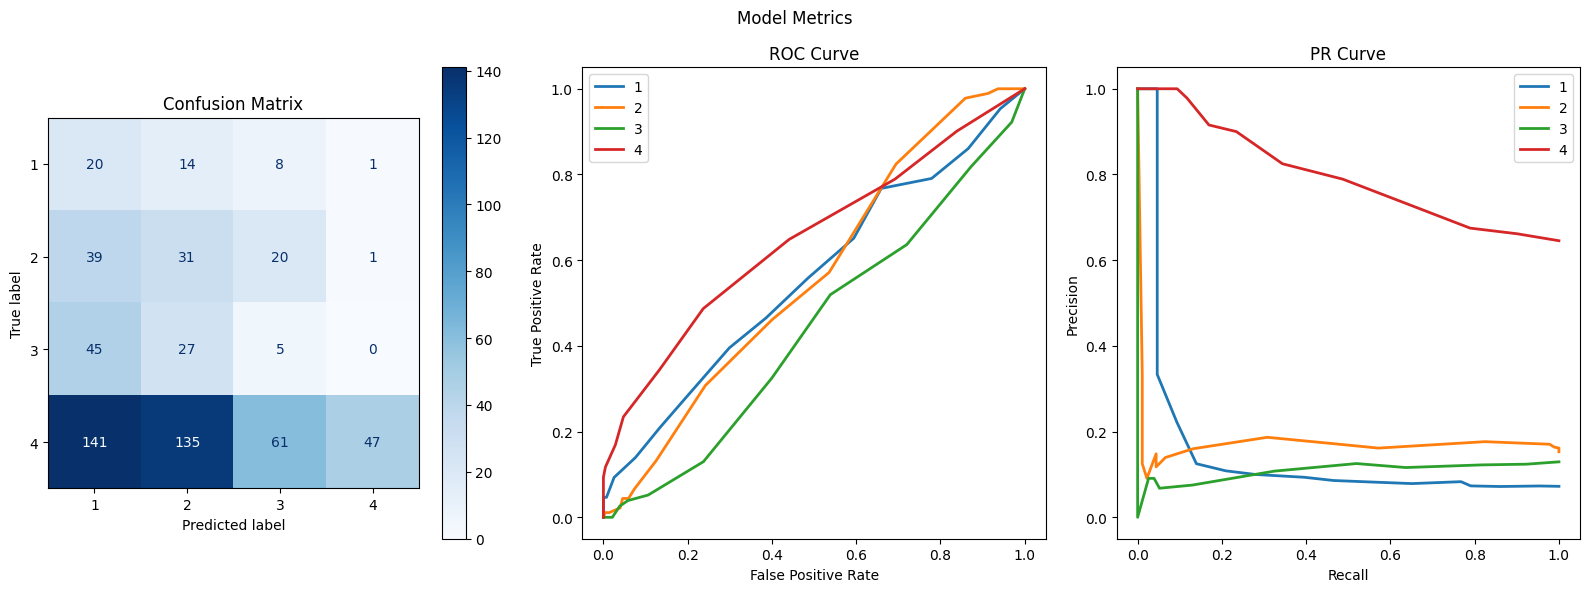

In [218]:
fancy_metric_vis(knn_head_of_household_adjusted_classes, X_test, y_test)

### Some graphs

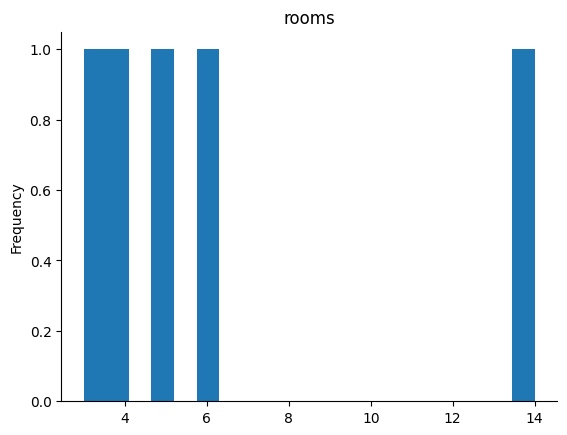

In [91]:
from matplotlib import pyplot as plt
_df_1['rooms'].plot(kind='hist', bins=20, title='rooms')
plt.gca().spines[['top', 'right',]].set_visible(False)

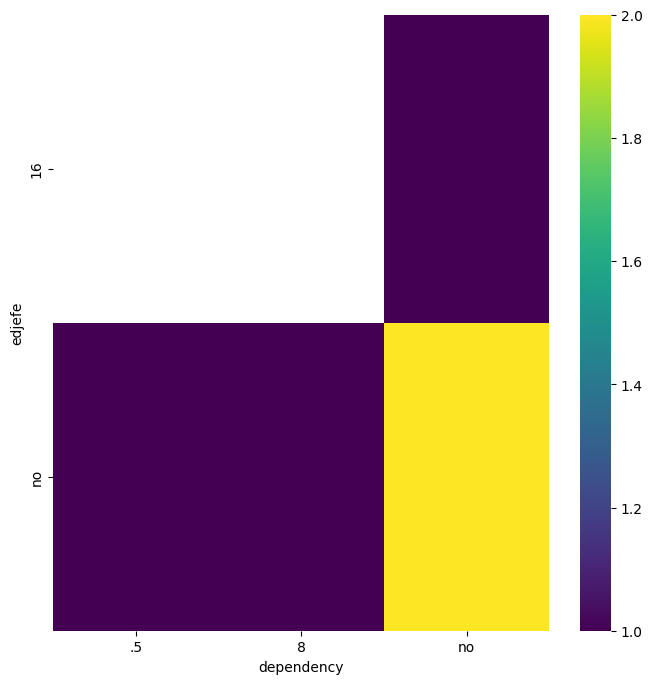

In [89]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['edjefe'].value_counts()
    for x_label, grp in _df_22.groupby('dependency')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('dependency')
_ = plt.ylabel('edjefe')

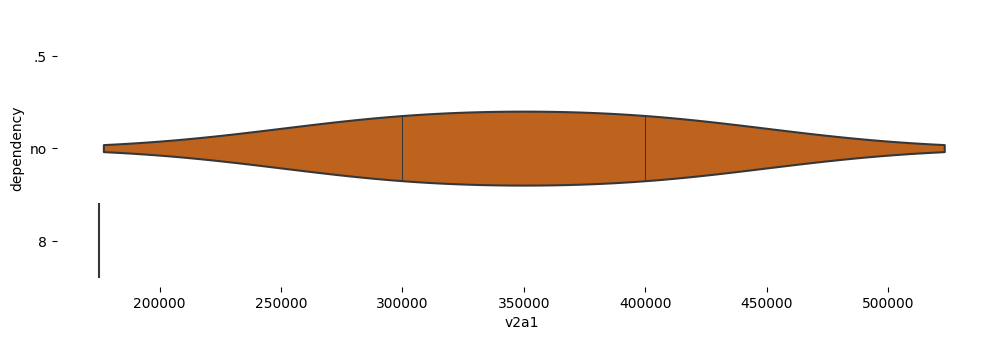

In [88]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['dependency'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='v2a1', y='dependency', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

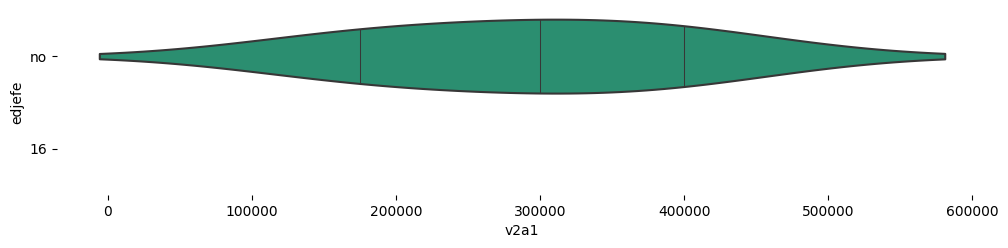

In [87]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['edjefe'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='v2a1', y='edjefe', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [77]:
test_data_heads_of_household_original.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324
6,ID_3c5f4bd51,400000.0,0,3,0,1,1,1,1.0,0,...,42,121,1764,4,0,0,1.00,0.00,182.25,1764
8,ID_472fa82da,300000.0,0,6,0,1,1,1,1.0,0,...,22,196,484,4,0,0,0.25,0.00,196.00,484


## train_data_heads_of_household_additional_stats

In [222]:
features = train_data_heads_of_household_additional_stats.drop('Target', axis=1)
target = train_data_heads_of_household_additional_stats['Target']

features.drop('Id', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

handled_missing_values = []
for col in X_train.select_dtypes(include='number').columns:
    mean_value = X_train[col].mean()
    X_train[col].fillna(mean_value, inplace=True)
    X_test[col].fillna(mean_value, inplace=True)
    handled_missing_values.append(col)

print("Handled missing values in columns:", handled_missing_values)

label_encoders = {}
encoded_columns = []
for column in X_train.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X_train[column] = label_encoders[column].fit_transform(X_train[column])
    X_test[column] = label_encoders[column].transform(X_test[column])
    encoded_columns.append(column)

print("Encoded categorical variables in columns:", encoded_columns)

Handled missing values in columns: ['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'tamhog', 'tamviv', 'hhsize', 'paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera', 'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6', 'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total', 'meaneduc', 'bedrooms', 'overcrowding', 'tipovivi1', 'tipovivi2', '

In [224]:
knn_additional_values = KNeighborsClassifier(n_neighbors=20)
knn_additional_values.fit(X_train, y_train)

y_pred = knn_additional_values.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy for k=20: {accuracy}")

Accuracy for k=20: 0.6386554621848739


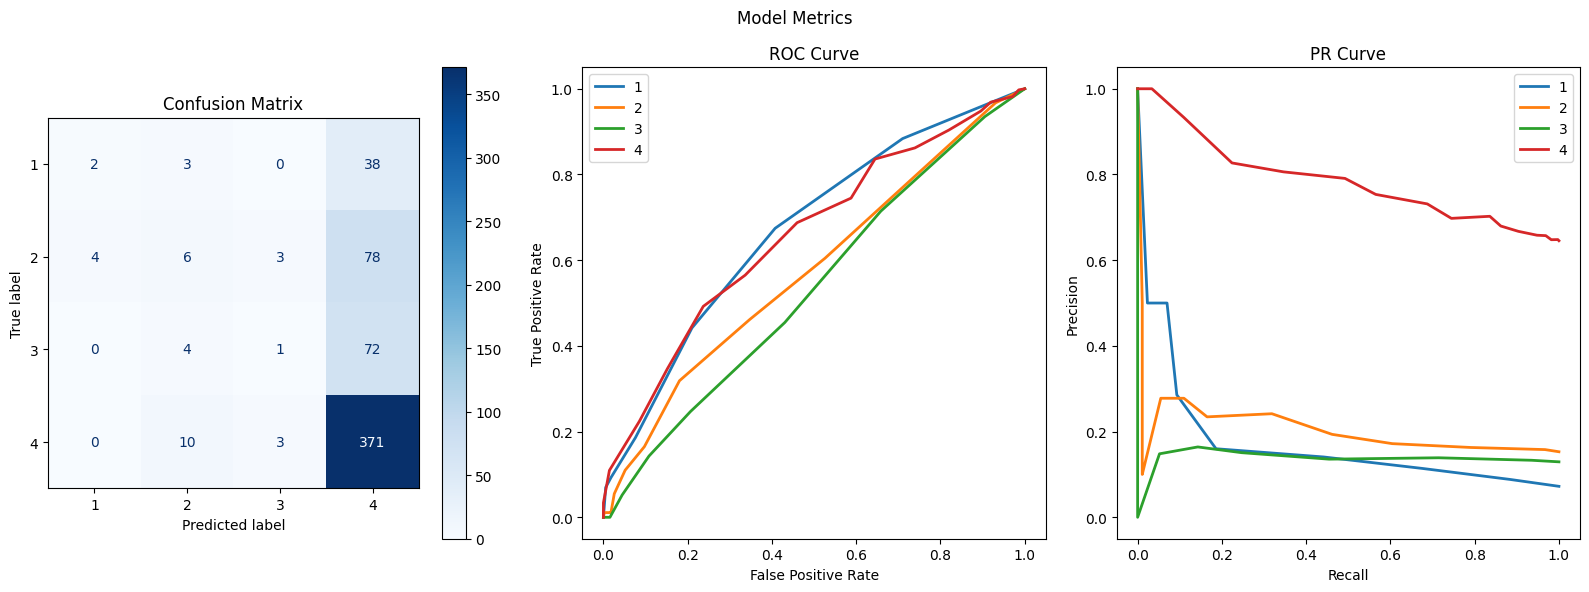

In [225]:
fancy_metric_vis(knn_additional_values, X_test, y_test)

In [258]:
test_data_heads_of_household_additional_stats.drop('Id', axis=1, inplace=True)

predictions = knn_additional_values.predict(test_data_heads_of_household_additional_stats)

In [259]:
# Extracting the household head IDs from the original test_data
household_head_ids = test_data.loc[test_data['parentesco1'] == 1, 'Id']

# Creating a DataFrame with IDs and predictions
household_head_predictions = pd.DataFrame({
    'Id': household_head_ids.values,
    'Target': predictions
})

In [260]:
# Creating a mapping from idhogar to Target
idhogar_to_target = dict(zip(test_data[test_data['parentesco1'] == 1]['idhogar'], predictions))

# Assigning Target values to all members in test_data based on their idhogar
test_data['Target'] = test_data['idhogar'].map(idhogar_to_target)

# Handling cases where some idhogar might not have a household head
# This can be handled in various ways, here we assign a default value (e.g., the most common Target value)
default_target = test_data['Target'].mode()[0]
test_data['Target'] = test_data['Target'].fillna(default_target).astype(int)

# Extracting final Id and Target values
final_predictions = test_data[['Id', 'Target']]

In [261]:
len(final_predictions)

23856